# setup

In [1]:
import os
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.applications.resnet50 as resnet50
import tensorflow.keras.applications.efficientnet_v2 as efficientnet_v2
import tensorflow.keras.applications.vgg19 as vgg19
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
!pip install tensorflow==2.10.1 # Install an older version of tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 34.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [1]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

NameError: name 'tf' is not defined

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
img_size =224
train_dir = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/new_updated_categories/train'
validation_dir = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/new_updated_categories/validation'
data_dir = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/'
batch_size = 16

In [ ]:
def similar_images(indices, filenames):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,5,plotnumber)
            print(filenames[index])
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plotnumber+=1
    plt.tight_layout()



def retrieve_similar_images(img_path, model, model_name, feature_list, filenames):
    file_paths = [os.path.join(data_dir, file_name) for file_name in filenames]
    # read and preprocess the image
    input_shape = (img_size, img_size, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)

    if model_name == 'resnet' or model_name == 'resnet50':
        preprocessed_img = resnet50.preprocess_input(expanded_img_array)
    elif model_name == 'vgg' or model_name == 'vgg19':
        preprocessed_img = vgg19.preprocess_input(expanded_img_array)
    else:
        preprocessed_img = efficientnet_v2.preprocess_input(expanded_img_array)

    neighbors = NearestNeighbors(n_neighbors=10,
                             algorithm='ball_tree',
                             metric='euclidean')
    neighbors.fit(feature_list)

    # predict the features of the using the resnet model
    test_img_features = model.predict(preprocessed_img, batch_size=1)

    # get the most similar images indices using KNN
    _, indices = neighbors.kneighbors(test_img_features)

    # print the original image and the 10 most similar images
    plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
    plt.xlabel('Original Image',fontsize=20)
    plt.show()
    print('********* Predictions ***********')
    similar_images(indices[0], file_paths)

    return

# Pretrained

## functions

In [ ]:
def feature_extraction(model_name, img_size, batch_size=16):

  # define the model used for feature extraction
  if model_name == 'vgg19':
    model = VGG19(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
    img_gen = ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)
  elif model_name == 'efficientnet':
    model = EfficientNetV2B3(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
    img_gen = ImageDataGenerator(preprocessing_function=efficientnet_v2.preprocess_input)
  else:
    model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
    img_gen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)


  # read the data
  datagen = img_gen.flow_from_directory(data_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

  # extract the features
  feature_list = model.predict(datagen, verbose = 1)

  print("Num images   = ", len(datagen.classes))
  print("Shape of feature_list = ", feature_list.shape)

  # return the extracted features along with the datagenerator

  # datagen.class_indices returns a dictionary with the name of the class as a key and the number as a value
  # datagen.classes return a labels array for the data

  return model, feature_list, datagen

In [ ]:
def evaluate_pretrained(feature_list, labels, test_split=0.1):
    X_train, X_test, y_train, y_test = train_test_split(feature_list, labels, test_size=0.1, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=15)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

## VGG

In [ ]:
vgg_model_pretrained, vgg_feature_list_pretrained, vgg_datagen = feature_extraction('vgg19', img_size, batch_size)

Found 3341 images belonging to 12 classes.
209/209 [==============================] - 18s 87ms/step
Num images   =  3341
Shape of feature_list =  (3341, 512)


In [ ]:
vgg_accuracy = evaluate_pretrained(vgg_feature_list, vgg_datagen.classes, 0.1)
vgg_accuracy

0.5552238805970149

1/1 [==============================] - 0s 20ms/step


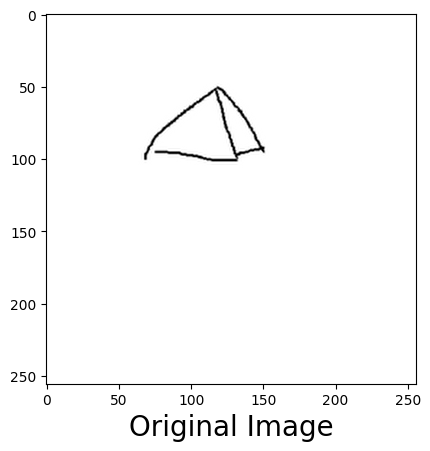

********* Predictions ***********
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_1171.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_3232.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-2_Distorted Prism  Form\train_fullStroke_1072.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/3-4 Cylindrical Segment\train_fullStroke_1746.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/3-4 Cylindrical Segment\train_fullStroke_1546.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_1036.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-2_Distorted Prism  Form\train_fullStroke_3104.png
C:/Users/20127/Desktop/sketch_retrieval/d

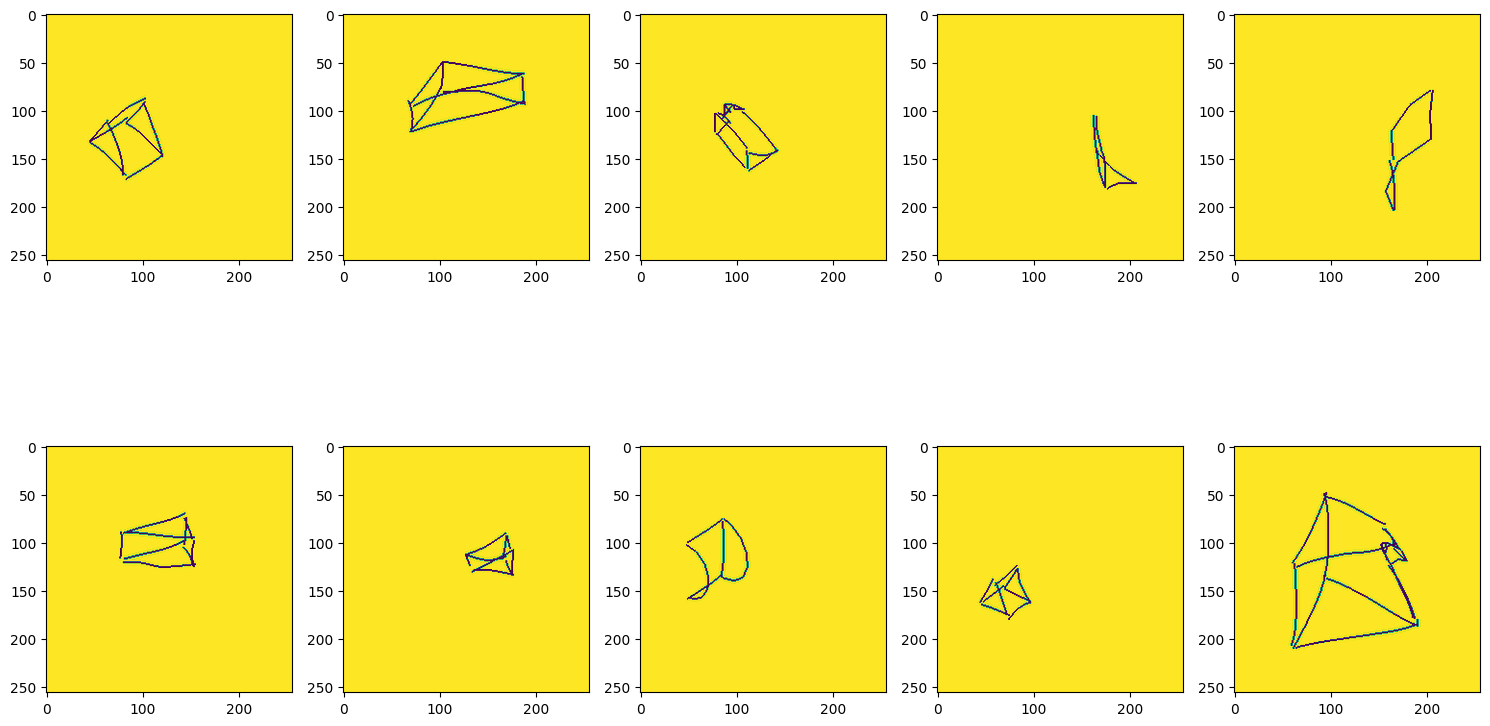

In [ ]:
test_image = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/test_images/testing_samples/2-2.png'
retrieve_similar_images(test_image, vgg_model, 'vgg', vgg_feature_list, vgg_datagen.filenames)

## ResNet

In [ ]:
resnet_model_pretrained, resnet_feature_list_pretrained, resnet_datagen = feature_extraction('resnet', img_size, batch_size)

Found 3341 images belonging to 12 classes.
209/209 [==============================] - 29s 104ms/step
Num images   =  3341
Shape of feature_list =  (3341, 2048)


In [ ]:
resnet_accuracy = evaluate_pretrained(resnet_feature_list_pretrained, resnet_datagen.classes, 0.1)
resnet_accuracy

0.5582089552238806

1/1 [==============================] - 0s 372ms/step


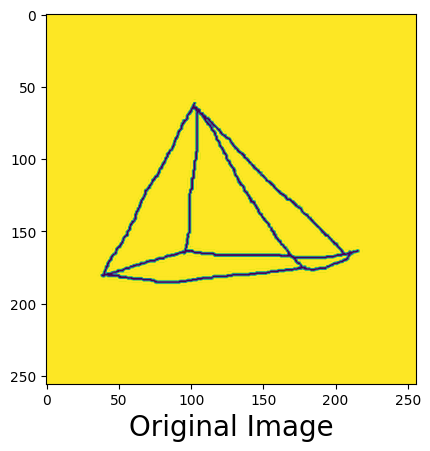

********* Predictions ***********
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_4615.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_1837.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_573.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_872.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_3688.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-2_Distorted Prism  Form\train_fullStroke_2630.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_418.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/upda

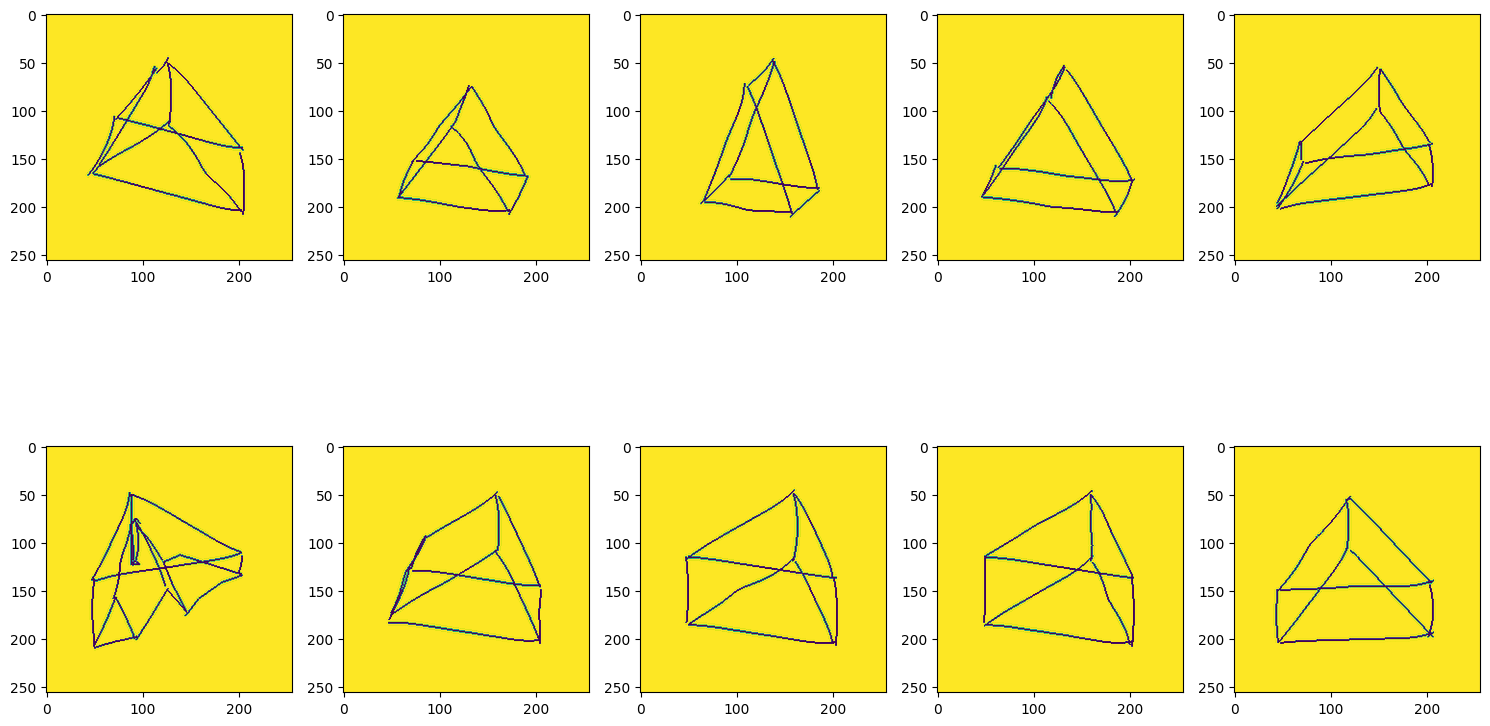

In [ ]:
test_image = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/test_images/testing_samples/2-3.png'

retrieve_similar_images(test_image, resnet_model_pretrained, 'resnet', resnet_feature_list_pretrained, resnet_datagen.filenames)

## EfficientNet

In [ ]:
efficientnet_model_pretrained, efficientnet_feature_list_pretrained, efficientnet_datagen = feature_extraction('efficientnet', img_size, batch_size)

Found 3341 images belonging to 12 classes.
209/209 [==============================] - 12s 44ms/step
Num images   =  3341
Shape of feature_list =  (3341, 1536)


In [ ]:
efficientnet_accuracy = evaluate_pretrained(efficientnet_feature_list_pretrained, efficientnet_datagen.classes, 0.1)
efficientnet_accuracy

0.591044776119403

1/1 [==============================] - 0s 30ms/step


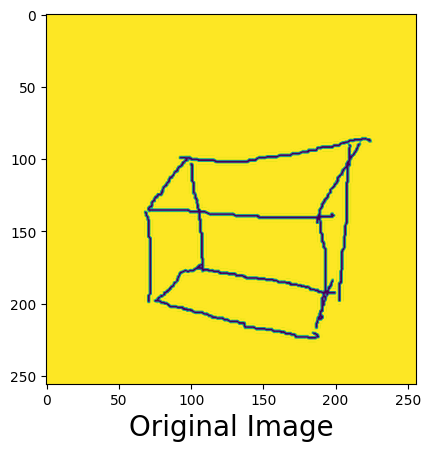

********* Predictions ***********
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-3_Conjoined Prism Form\train_fullStroke_4762.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/1-3_Conjoined 3D Rectangles\train_fullStroke_4556.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/2-2_Distorted Cube\train_fullStroke_555.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/2-3_Conjoined Cube Form\train_fullStroke_4197.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-2_Distorted Prism  Form\train_fullStroke_567.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/1-2_Distorted 3D Rectangles\train_fullStroke_57.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/1-3_Conjoined 3D Rectangles\train_fullStroke_4351.png
C:/Users/20127/

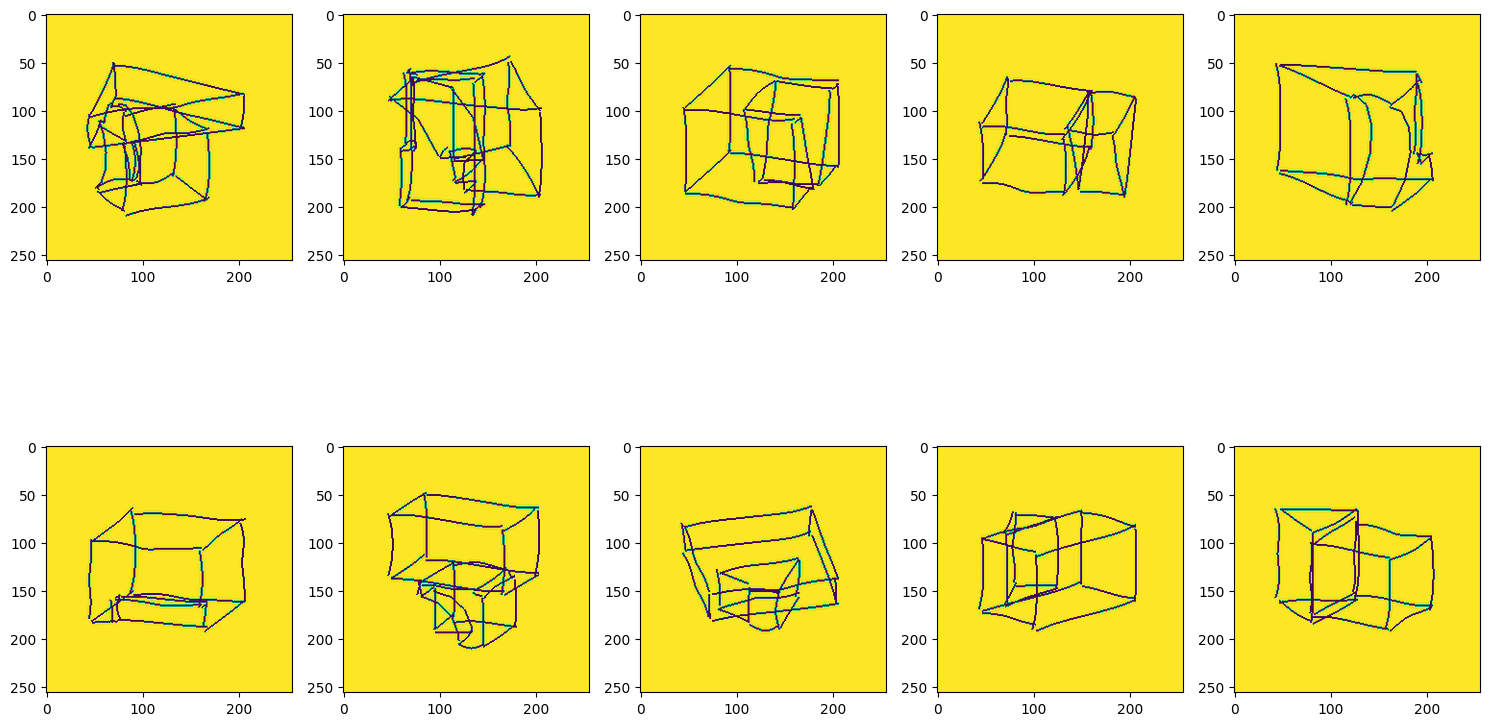

In [ ]:
test_image = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/test_images/testing_samples/4-1.png'

retrieve_similar_images(test_image, efficientnet_model_pretrained, 'efficientnet', efficientnet_feature_list_pretrained, efficientnet_datagen.filenames)

# Training

## VGG19

In [ ]:
# loading the data
vgg_train_datagen = ImageDataGenerator(preprocessing_function=vgg19.preprocess_input,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2)

vgg_train_generator = vgg_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

vgg_validation_datagen =  ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

vgg_validation_generator = vgg_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',) # set as validation data

In [ ]:
# model architecture
vgg_feature_extractor = VGG19(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
vgg_feature_extractor.trainable = True

vgg_model = tf.keras.Sequential([
    vgg_feature_extractor,
    tf.keras.layers.Dense(12, name="Output_layer", activation="softmax")
  ])

In [ ]:
vgg_model.summary()

In [ ]:
vgg_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
vgg_history = vgg_model.fit(vgg_train_generator,
                              steps_per_epoch = vgg_train_generator.samples // batch_size,
                              validation_data = vgg_validation_generator,
                              validation_steps = vgg_validation_generator.samples // batch_size,
                              epochs = 10)

In [ ]:
vgg_model.save('C:/Users/20127/Desktop/sketch_retrieval/vgg_model')

## RESNET50

In [ ]:
# loading the data
# resnet_train_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input,
#                                               rescale=1.0/255,
#                                               rotation_range=40,
#                                               width_shift_range=0.2,
#                                               height_shift_range=0.2,
#                                               shear_range=0.2,
#                                               zoom_range=0.2,
#                                               horizontal_flip=True,
#                                               fill_mode='nearest')

resnet_train_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

resnet_train_generator = resnet_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

# resnet_validation_datagen =  ImageDataGenerator(preprocessing_function=resnet50.preprocess_input,
#                                               rescale=1.0/255,
#                                               rotation_range=40,
#                                               width_shift_range=0.2,
#                                               height_shift_range=0.2,
#                                               shear_range=0.2,
#                                               zoom_range=0.2,
#                                               horizontal_flip=True,
#                                               fill_mode='nearest')

resnet_validation_datagen =  ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

resnet_validation_generator = resnet_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',) # set as validation data

In [ ]:
# model architecture
resnet_feature_extractor = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

resnet_feature_extractor.trainable = False

resnet_model = tf.keras.Sequential([
    resnet_feature_extractor,
    tf.keras.layers.Dense(12, name="Output_layer", activation="softmax")
  ])

In [ ]:
resnet_model.layers[0].trainable

In [ ]:
resnet_model.summary()

In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=5,              # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)


resnet_history = resnet_model.fit(resnet_train_generator,
                              steps_per_epoch = resnet_train_generator.samples // batch_size,
                              validation_data = resnet_validation_generator,
                              validation_steps = resnet_validation_generator.samples // batch_size,
                              epochs = 15, callbacks=[early_stopping])

In [ ]:
len(resnet_model.layers[0].layers)

In [ ]:
resnet_model.layers[0].trainable = True
resnet_model.layers[0].trainable

In [ ]:
for layer in resnet_model.layers[0].layers[:100]:
    layer.trainable = False
for layer in resnet_model.layers[0].layers[100:]:
    layer.trainable = True

In [ ]:
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,              # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)


resnet_history = resnet_model.fit(resnet_train_generator,
                              steps_per_epoch = resnet_train_generator.samples // batch_size,
                              validation_data = resnet_validation_generator,
                              validation_steps = resnet_validation_generator.samples // batch_size,
                              epochs = 30, callbacks=[early_stopping])

In [ ]:
resnet_model.save('C:/Users/20127/Desktop/sketch_retrieval/resnet_model_2')

## EfficientNetV2

In [ ]:
efficientnet_train_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

efficientnet_train_generator = efficientnet_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical') # set as training data



efficientnet_validation_datagen =  ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

efficientnet_validation_generator = efficientnet_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',) # set as validation data

Found 5331 images belonging to 12 classes.
Found 597 images belonging to 12 classes.


In [ ]:
# model architecture
efficientnet_feature_extractor = EfficientNetV2B3(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
efficientnet_feature_extractor.trainable = False

efficientnet_model = tf.keras.Sequential([
    efficientnet_feature_extractor,
    tf.keras.layers.Dense(12, name="Output_layer", activation="softmax")
  ])

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 1536)             12930622  
 al)                                                             
                                                                 
 Output_layer (Dense)        (None, 12)                18444     
                                                                 
Total params: 12,949,066
Trainable params: 18,444
Non-trainable params: 12,930,622
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=15,              # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)


efficientnet_history = efficientnet_model.fit(efficientnet_train_generator,
                              steps_per_epoch = efficientnet_train_generator.samples // batch_size,
                              validation_data = efficientnet_validation_generator,
                              validation_steps = efficientnet_validation_generator.samples // batch_size,
                              epochs = 30, callbacks=[early_stopping])

Epoch 1/30
333/333 [==============================] - 60s 155ms/step - loss: 2.0865 - accuracy: 0.4344 - val_loss: 1.2166 - val_accuracy: 0.5845
Epoch 2/30
333/333 [==============================] - 51s 153ms/step - loss: 1.5691 - accuracy: 0.5451 - val_loss: 1.0065 - val_accuracy: 0.6655
Epoch 3/30
333/333 [==============================] - 50s 149ms/step - loss: 1.4307 - accuracy: 0.5804 - val_loss: 1.0870 - val_accuracy: 0.6639
Epoch 4/30
333/333 [==============================] - 49s 148ms/step - loss: 1.4594 - accuracy: 0.5883 - val_loss: 0.9522 - val_accuracy: 0.6824
Epoch 5/30
333/333 [==============================] - 51s 152ms/step - loss: 1.3810 - accuracy: 0.6211 - val_loss: 0.9325 - val_accuracy: 0.6824
Epoch 6/30
333/333 [==============================] - 51s 154ms/step - loss: 1.3986 - accuracy: 0.6175 - val_loss: 0.9212 - val_accuracy: 0.6926
Epoch 7/30
333/333 [==============================] - 54s 162ms/step - loss: 1.3171 - accuracy: 0.6271 - val_loss: 1.0699 - val_ac

In [ ]:
len(efficientnet_model.layers[0].layers)

410

In [ ]:
efficientnet_model.layers[0].trainable = True
efficientnet_model.layers[0].trainable

True

In [ ]:
for layer in efficientnet_model.layers[0].layers[:-100]:
  layer.trainable = False

for layer in efficientnet_model.layers[0].layers[-100:]:
  layer.trainable = True

In [ ]:
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,              # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)


efficientnet_history = efficientnet_model.fit(efficientnet_train_generator,
                              steps_per_epoch = efficientnet_train_generator.samples // batch_size,
                              validation_data = efficientnet_validation_generator,
                              validation_steps = efficientnet_validation_generator.samples // batch_size,
                              epochs = 30, callbacks=[early_stopping])

Epoch 1/30
333/333 [==============================] - 50s 149ms/step - loss: 1.1561 - accuracy: 0.6815 - val_loss: 0.7864 - val_accuracy: 0.7720
Epoch 2/30
333/333 [==============================] - 50s 149ms/step - loss: 1.2323 - accuracy: 0.6762 - val_loss: 1.0504 - val_accuracy: 0.7162
Epoch 3/30
333/333 [==============================] - 52s 155ms/step - loss: 1.1683 - accuracy: 0.6753 - val_loss: 1.0603 - val_accuracy: 0.6993
Epoch 4/30
333/333 [==============================] - 50s 149ms/step - loss: 1.1500 - accuracy: 0.6864 - val_loss: 1.2027 - val_accuracy: 0.6943
Epoch 5/30
333/333 [==============================] - 51s 152ms/step - loss: 1.1934 - accuracy: 0.6771 - val_loss: 0.9011 - val_accuracy: 0.7331
Epoch 6/30
333/333 [==============================] - 52s 155ms/step - loss: 1.2341 - accuracy: 0.6738 - val_loss: 0.8955 - val_accuracy: 0.7213
Epoch 7/30
333/333 [==============================] - 51s 154ms/step - loss: 1.2245 - accuracy: 0.6743 - val_loss: 0.9829 - val_ac

In [ ]:
efficientnet_model.save('C:/Users/20127/Desktop/sketch_retrieval/efficientnet_model_2')

INFO:tensorflow:Assets written to: C:/Users/20127/Desktop/sketch_retrieval/efficientnet_model_2\assets


INFO:tensorflow:Assets written to: C:/Users/20127/Desktop/sketch_retrieval/efficientnet_model_2\assets


# Image search ResNet50

In [ ]:
resnet_model = load_model('C:/Users/20127/Desktop/sketch_retrieval/resnet_model_2')

In [ ]:
resnet_train_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

resnet_train_generator = resnet_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as training data

resnet_validation_datagen =  ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

resnet_validation_generator = resnet_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as validation data

Found 5331 images belonging to 12 classes.
Found 597 images belonging to 12 classes.


In [ ]:
resnet_test_datagen =  ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
resnet_test_generator = resnet_test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as validation data

Found 3341 images belonging to 12 classes.


In [ ]:
feature_extractor_resnet_model = resnet_model.layers[0]

In [ ]:
X_train = feature_extractor_resnet_model.predict(resnet_train_generator)
y_train = resnet_train_generator.classes

X_test = feature_extractor_resnet_model.predict(resnet_validation_generator)
y_test = resnet_validation_generator.classes

19/19 [==============================] - 3s 137ms/step


In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5331, 2048), (5331,), (597, 2048), (597,))

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.678391959798995


In [ ]:
resnet_feature_list = feature_extractor_resnet_model.predict(resnet_test_generator)

105/105 [==============================] - 11s 104ms/step


1/1 [==============================] - 0s 31ms/step


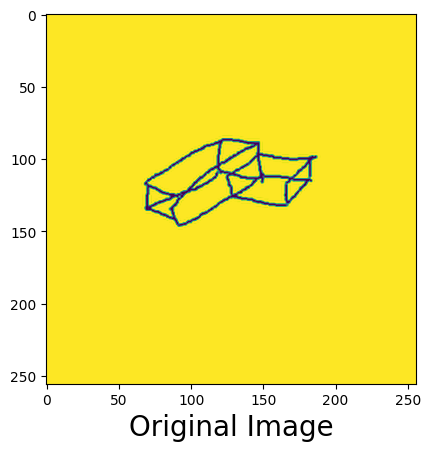

********* Predictions ***********
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/2-3_Conjoined Cube Form\train_fullStroke_2210.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/1-2_Distorted 3D Rectangles\train_fullStroke_2557.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/1-3_Conjoined 3D Rectangles\train_fullStroke_2981.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/1-2_Distorted 3D Rectangles\train_fullStroke_906.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/1-3_Conjoined 3D Rectangles\train_fullStroke_2403.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/3-4 Cylindrical Segment\train_fullStroke_2276.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/2-3_Conjoined Cube Form\train_fullStroke_2609.png
C:/Use

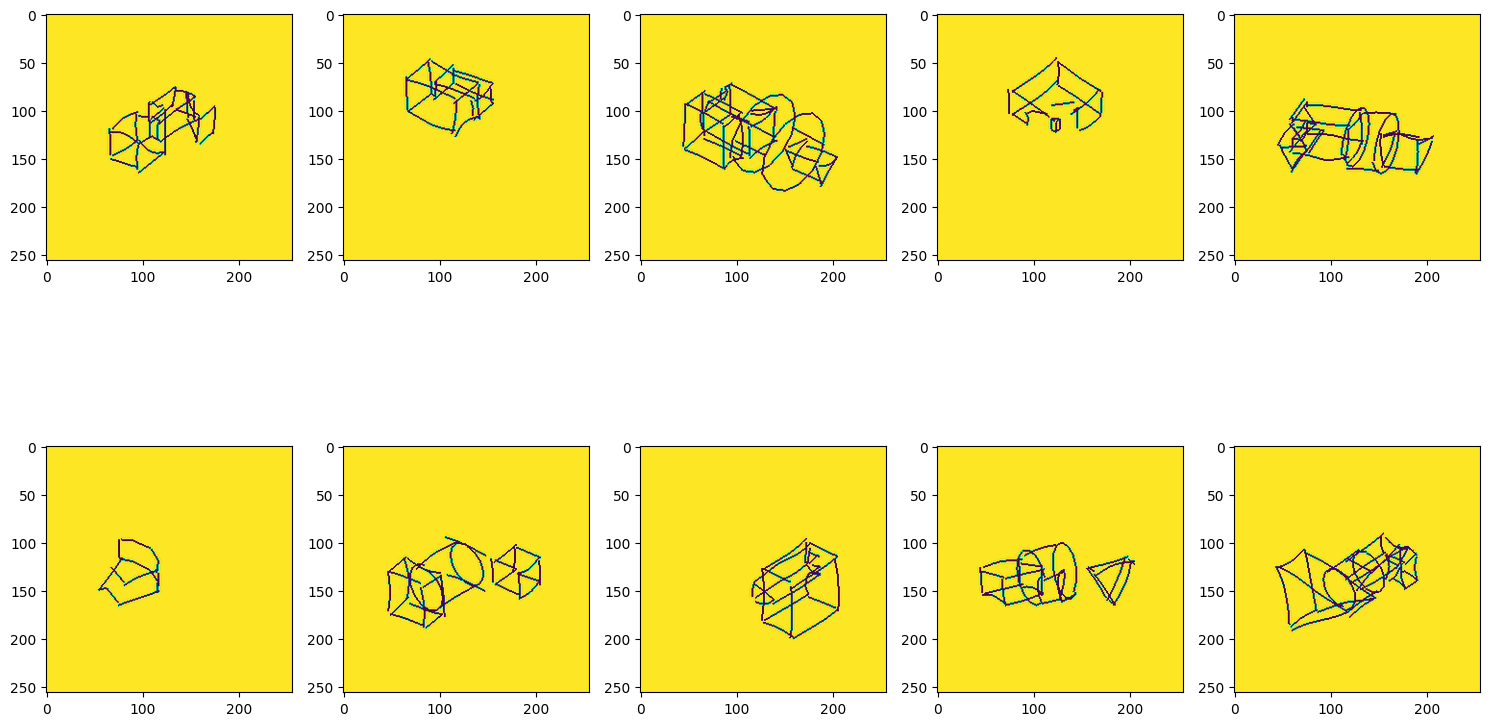

In [ ]:
test_image = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/test_images/testing_samples/5-1.png'

retrieve_similar_images(test_image, feature_extractor_resnet_model, 'resnet', resnet_feature_list, resnet_test_generator.filenames)

# Image search VGG

In [ ]:
vgg_model = load_model('C:/Users/20127/Desktop/sketch_retrieval/vgg_model')

In [ ]:
vgg_train_datagen = ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)

vgg_train_generator = vgg_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as training data

vgg_validation_datagen =  ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)

vgg_validation_generator = vgg_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as validation data

In [ ]:
vgg_test_datagen =  ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)
vgg_test_generator = vgg_test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as validation data

In [ ]:
feature_extractor_vgg_model = vgg_model.layers[0]

In [ ]:
X_train_vgg = feature_extractor_vgg_model.predict(vgg_train_generator)
y_train_vgg = vgg_train_generator.classes
X_test_vgg = feature_extractor_vgg_model.predict(vgg_validation_generator)
y_test_vgg = vgg_validation_generator.classes

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_vgg, y_train_vgg)

In [ ]:
y_pred_vgg = knn.predict(X_test_vgg)

In [ ]:
accuracy = accuracy_score(y_test_vgg, y_pred_vgg)
print("Accuracy:", accuracy)

In [ ]:
vgg_feature_list = feature_extractor_vgg_model.predict(vgg_test_generator)

# Image Search EfficientNet

In [ ]:
tf.__version__

'2.10.1'

In [ ]:
efficientnet_model = load_model('C:/Users/20127/Desktop/sketch_retrieval/efficientnet_model/')

In [ ]:
efficientnet_train_datagen = ImageDataGenerator(preprocessing_function=efficientnet_v2.preprocess_input)

efficientnet_train_generator = efficientnet_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as training data

efficientnet_validation_datagen =  ImageDataGenerator(preprocessing_function=efficientnet_v2.preprocess_input)

efficientnet_validation_generator = efficientnet_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as validation data

Found 5331 images belonging to 12 classes.
Found 597 images belonging to 12 classes.


In [ ]:
efficientnet_test_datagen =  ImageDataGenerator(preprocessing_function=efficientnet_v2.preprocess_input)
efficientnet_test_generator = efficientnet_test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    class_mode=None,
    shuffle=False) # set as validation data

Found 3341 images belonging to 12 classes.


In [ ]:
feature_extractor_efficientnet_model = efficientnet_model
#efficientnet_model.layers[0]

In [ ]:
X_train_efficientnet = feature_extractor_efficientnet_model.predict(efficientnet_train_generator)
y_train_efficientnet = efficientnet_train_generator.classes
X_test_efficientnet = feature_extractor_efficientnet_model.predict(efficientnet_validation_generator)
y_test_efficientnet = efficientnet_validation_generator.classes

19/19 [==============================] - 2s 126ms/step


In [ ]:
X_train_efficientnet.shape, y_train_efficientnet.shape, X_test_efficientnet.shape, y_test_efficientnet.shape

((5331, 12), (5331,), (597, 12), (597,))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_efficientnet, y_train_efficientnet)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
y_pred_efficientnet = knn.predict(X_test_efficientnet)

In [ ]:
accuracy = accuracy_score(y_test_efficientnet, y_pred_efficientnet)
print("Accuracy:", accuracy)

Accuracy: 0.8492462311557789


In [ ]:
efficientnet_feature_list = feature_extractor_efficientnet_model.predict(efficientnet_test_generator)

105/105 [==============================] - 20s 189ms/step


1/1 [==============================] - 0s 43ms/step


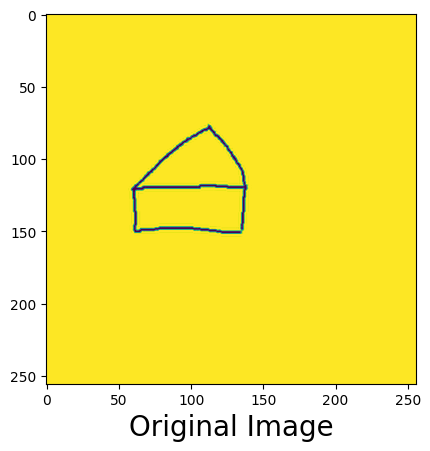

********* Predictions ***********
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_1681.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_1588.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_1415.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_4146.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_2666.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_3816.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_categories/4-1_Prism  Form\train_fullStroke_2958.png
C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/updated_cat

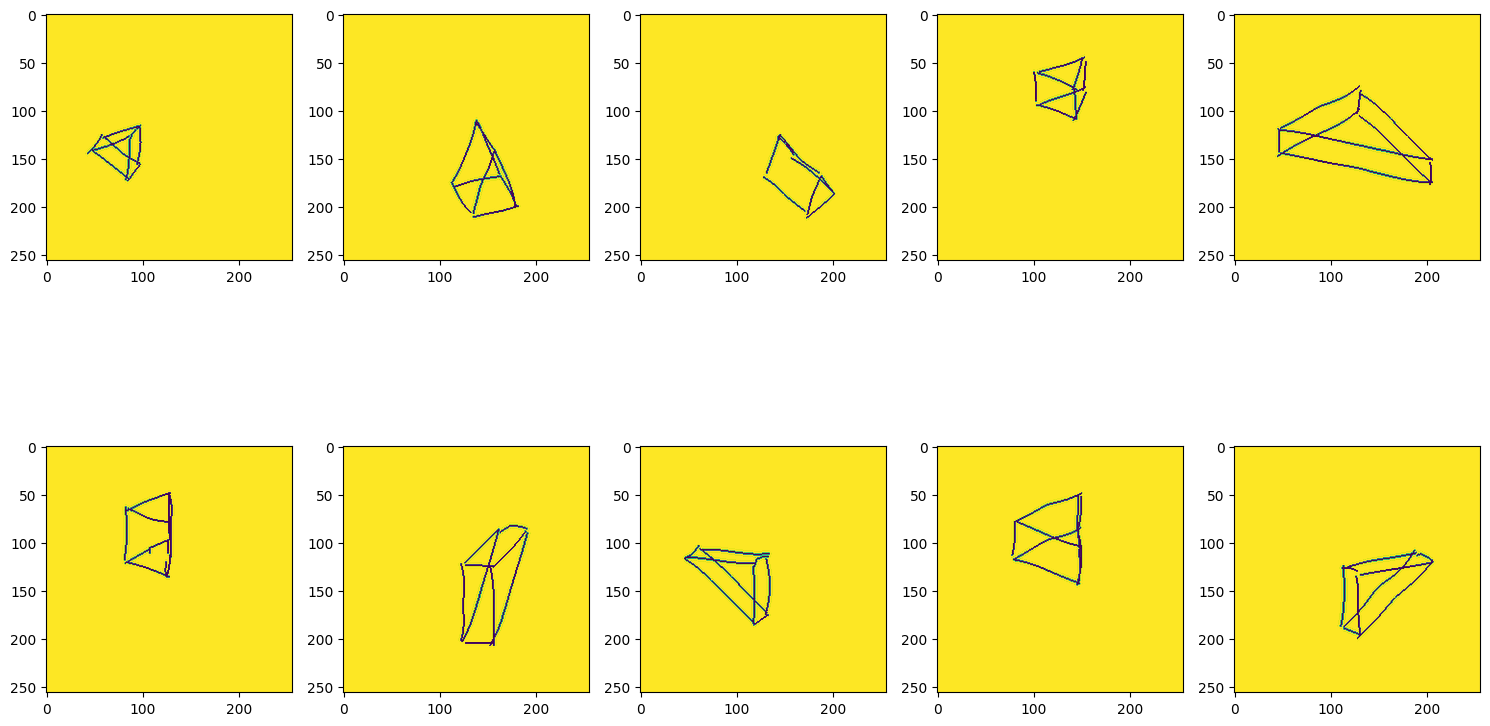

In [ ]:
test_image = 'C:/Users/20127/Desktop/sketch_retrieval/dataset_mine/dataset_mine/test_images/testing_samples/3-1.png'

retrieve_similar_images(test_image, feature_extractor_efficientnet_model, 'efficientnet', efficientnet_feature_list, efficientnet_test_generator.filenames)